# Contenido (hipervínculos)

1. <a href="L2D"> Modelo </a>

2. <a href="#caso1">Caso 1: Cilindro sumergido</a>

3. <a href="#caso2"> Caso 2: Isla cónica (NOAA)</a>

4. <a href="#caso3"> Caso 3: Chile 2010 (Moreno)</a>

In [1]:
import time

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import loadmat

# Simple case

In [3]:
R_earth = 6378000.
rad_deg = 0.01745329252
rad_min = 0.000290888208665721
cori_w = 7.2722e-5
g = 9.81
gx  =1e-1

In [4]:
import utm

In [9]:
x = np.linspace(-30,30.0,61) #in degrees
y = np.linspace(-30,30.0,61)
xmesh, ymesh = np.meshgrid(x,y,indexing='ij')

nx = x.shape[0]
ny = y.shape[0]
dx = np.diff(x)[0]*60 #in minutes
dy = np.diff(y)[0]*60 #in minutes
lat_max = max(abs(y[0]),abs(y[-1]))*rad_deg
dx_real = R_earth*np.cos(lat_max)*dx*rad_min
dy_real = R_earth*dy*rad_min
dt = 0.45*min(dx_real,dy_real)/np.sqrt(g*np.max(h))
print dt

195.877937343


(-30.0, 30.0, -30.0, 30.0)

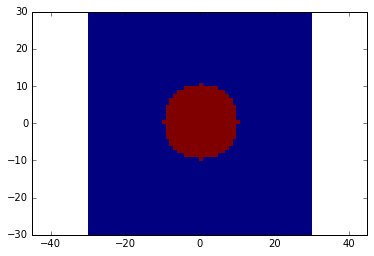

In [10]:
h = np.ones_like(xmesh)*1000
L = x.max()-x.min()
h = np.where(xmesh**2+ymesh**2<=(L/6)**2,5000,h)
plt.pcolormesh(xmesh,ymesh,h)
plt.axis('equal')

In [11]:
RR = dt/R_earth
angM = ymesh*rad_deg
cosM = np.cos(angM)
sinM = np.sin(angM)
R1 = RR/(cosM*dx*rad_min)
R11 = RR/(cosM*dy*rad_min)
R6 = np.cos((ymesh+0.5*dy/60.0)*rad_deg)
print 'RR',RR
print 'R1',R1.min(),R1.max()
print 'R11', R11.min(),R11.max()
print 'R6', R6.min(), R6.max()

RR 3.07114984858e-05
R1 0.00175963924576 0.00203185638444
R11 0.00175963924576 0.00203185638444
R6 0.861629160441 0.999961923064


In [12]:
RS = g*RR
hp = h*1.0
hp[0:-1,:] = 0.5*(h[0:-1,:]+h[1:,:])
R2 = np.where(hp>0,RS/(cosM*dx*rad_min)*hp,0.0)
RT = 0.5*dt*cori_w
R3 = RT*sinM
print 'R2',R2.min(),R2.max()
print 'R3',R3.min(),R3.max()

R2 17.2620610009 87.3861738133
R3 -0.00356115883987 0.00356115883987


In [13]:
angN = (ymesh + 0.5*dy/60.)*rad_deg
sinN = np.sin(angN)
hq = h*1.0
hq[:,0:-1] = 0.5*(h[:,0:-1]+h[:,1:])
R4 = np.where(hq>0,RS/(dy*rad_min)*hq,0.0)
R5 = RT*sinN

In [14]:
nt = 210
eta = np.zeros((nt,nx,ny))
p = np.zeros_like(eta)
q = np.zeros_like(eta)

xmid = 0.3*x.max()+0.7*x.min()
ymid = 0.3*y.max()+0.7*y.min()
L = 0.15*(y.max()-y.min())
eta[0,:,:] = np.exp(-((xmesh-xmid)**2+(ymesh-ymid)**2)/L**2)

# eta[0,:,:] = np.exp(-((xmesh+27)**2+(y+27)**2)/10)*5.0
# eta[0,:,:] = np.where(h>0,eta[0,:,:],-h)

(-30.0, 30.0, -30.0, 30.0)

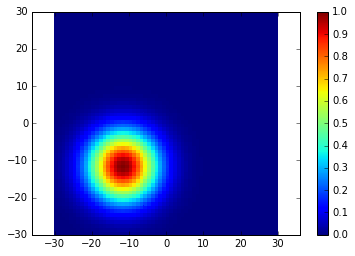

In [15]:
plt.pcolormesh(xmesh,ymesh,eta[0,:,:])
plt.colorbar()
plt.axis('equal')

In [16]:
def simulation(x,h,eta,p,q,R1,R11,R6,R2,R4,R5,nt,gx,debug=False):
    dp1 = np.zeros_like(x)
    dp2 = np.zeros_like(x)
    dq1 = np.zeros_like(x)
    dq2 = np.zeros_like(x)

    zdepth = np.zeros_like(eta)
    zdepth[0,:,:] = eta[0,:,:]+h

    t0 = time.clock()
    for n in range(nt-1):
        ## Mas Loop
        for i in range(1, nx-1):
            for j in range(1, ny-1):
                if (h[i,j]>gx):
                    zzz = eta[n,i,j] - R1[i,j]*(p[n,i,j]-p[n,i-1,j]) \
                                   - R11[i,j]*(q[n,i,j]*R6[i,j]-q[n,i,j-1]*R6[i,j-1])
                    DD = zzz + h[i,j]
                    zdepth[n+1,i,j] = DD
                    eta[n+1,i,j] = zzz    
                else:
                    eta[n+1,i,j] = 0.0
                    
        # open boundary
        
        j = 0
        for i in range(1,nx-1):
            if h[i,j]>gx:
                cc = np.sqrt(9.81*h[i,j])
                uh = 0.5*(p[n,i,j]+p[n,i-1,j])
                uu = np.sqrt(uh**2+q[n,i,j]**2)
                zz = uu/cc
                if q[n,i,j]>0:
                    zz = -zz
                eta[n+1,i,j] = zz
                zdepth[n+1,i,j] = zz+h[i,j]
            else:
                zz = 0.0
                eta[n+1,i,j] = zz
                zdepth[n+1,i,j] = zz+h[i,j]                        

        j = ny-1
        for i in range(1,nx-1):
            if h[i,j]>gx:
                cc = np.sqrt(9.81*h[i,j])
                uh = 0.5*(p[n,i,j]+p[n,i-1,j])
                uu = np.sqrt(uh**2+q[n,i,j-1]**2)
                zz = uu/cc
                if q[n,i,j-1]<0:
                    zz = -zz
                eta[n+1,i,j] = zz
                zdepth[n+1,i,j] = zz+h[i,j]
            else:
                zz = 0.0
                eta[n+1,i,j] = zz
                zdepth[n+1,i,j] = zz+h[i,j]                

        i = 0
        for j in range(1,ny-1):
            if h[i,j]>gx:
                cc = np.sqrt(9.81*h[i,j])
                if h[i,j-1]>gx:
                    uh = 0.5*(q[n,i,j]+q[n,i,j-1])
                else:
                    uh = q[n,i,j]
                uu = np.sqrt(uh**2+p[n,i,j]**2)
                zz = uu/cc
                if p[n,i,j]>0:
                    zz = -zz
                eta[n+1,i,j] = zz
                zdepth[n+1,i,j] = zz+h[i,j]
            else:
                zz = 0.0
                eta[n+1,i,j] = zz
                zdepth[n+1,i,j] = zz+h[i,j]

        i = nx-1
        for j in range(1,ny-1):
            if h[i,j]>gx:
                cc = np.sqrt(9.81*h[i,j])
                uh = 0.5*(q[n,i,j]+q[n,i,j-1])
                uu = np.sqrt(uh**2+p[n,i-1,j]**2)
                zz = uu/cc
                if p[n,i-1,j]<0:
                    zz = -zz
                eta[n+1,i,j] = zz     
                zdepth[n+1,i,j] = zz+h[i,j]
            else:
                zz = 0.0
                eta[n+1,i,j] = zz
                zdepth[n+1,i,j] = zz+h[i,j]


        i = 0
        j = 0
        if h[i,j]>gx:
            cc = np.sqrt(9.81*h[i,j])
            qx = p[n,i,j]
            qy = q[n,i,j]
            uu = np.sqrt(qx**2+qy**2)        
            zz = uu/cc
            if qx>0 or qy>0:
                zz = -zz
            eta[n+1,i,j] = zz
            zdepth[n+1,i,j] = zz+h[i,j]
        else:
            zz = 0.0
            eta[n+1,i,j] = zz
            zdepth[n+1,i,j] = zz+h[i,j]           

        i = nx-1
        j = 0
        if h[i,j]>gx:
            cc = np.sqrt(9.81*h[i,j])
            qx = p[n,i-1,j]
            qy = q[n,i,j]
            uu = np.sqrt(qx**2+qy**2)        
            zz = uu/cc
            if qx<0 or qy>0:
                zz = -zz
            eta[n+1,i,j] = zz
            zdepth[n+1,i,j] = zz+h[i,j]
        else:
            zz = 0.0
            eta[n+1,i,j] = zz
            zdepth[n+1,i,j] = zz+h[i,j]                 

        i = 0
        j = ny-1
        if h[i,j]>gx:
            cc = np.sqrt(9.81*h[i,j])
            qx = p[n,i,j]
            qy = q[n,i,j-1]
            uu = np.sqrt(qx**2+qy**2)        
            zz = uu/cc
            if qx>0 or qy<0:
                zz = -zz
            eta[n+1,i,j] = zz
            zdepth[n+1,i,j] = zz+h[i,j]
        else:
            zz = 0.0
            eta[n+1,i,j] = zz
            zdepth[n+1,i,j] = zz+h[i,j]

        i = nx-1
        j = ny-1
        if h[i,j]>gx:
            cc = np.sqrt(9.81*h[i,j])
            qx = p[n,i-1,j]
            qy = q[n,i,j-1]
            uu = np.sqrt(qx**2+qy**2)        
            zz = uu/cc
            if qx<0 or qy<0:
                zz = -zz
            eta[n+1,i,j] = zz
            zdepth[n+1,i,j] = zz+h[i,j]
        else:
            zz = 0.0
            eta[n+1,i,j] = zz
            zdepth[n+1,i,j] = zz+h[i,j]                         

        # momentum loop

        # momentum in x-direction
        for i in range(0,nx-1):
            for j in range(0,ny-1):
                ip1 = min(nx-1,i+1)
                jp1 = max(0,i-1)

                if h[i,j]>gx and h[ip1,j]>gx:
                    hM = 0.5*(h[i,j]+h[ip1,j]) + 0.5 *(eta[n+1,i,j]+eta[n+1,ip1,j])

                    p[n+1,i,j]  = p[n,i,j] - R2[i,j]* (eta[n+1,ip1,j]-eta[n+1,i,j])
                else:
                    p[n+1,i,j] = 0.0

        # momentum in y-direction
        for i in range(0,nx-1):
            for j in range(0,ny-1):
                ip1 = min(nx-1,i+1)
                jp1 = min(ny-1,j+1)

                if h[i,j]>gx and h[i,jp1]>gx:
    #                     hN = 0.5*(h[i,j]+h[i,jp1]) + 0.5 *(eta[n+1,i,j]+eta[n+1,i,jp1])
                    q[n+1,i,j]  = q[n,i,j] - R4[i,j]*(eta[n+1,i,jp1]-eta[n+1,i,j])
                else:
                    q[n+1,i,j] = 0.0  

        t1 = time.clock()    

        print '%.3f'%(n*1.0/nt), 'elapsed: %.3f s, estimated %.3f s:'%(t1-t0,(t1-t0)*nt*1.0/(n+1))
    return eta,p,q

In [17]:

eta,p,q = simulation(x,h,eta,p,q,R1,R11,R6,R2,R4,R5,nt,gx)


0.000 elapsed: 0.082 s, estimated 17.161 s:
0.005 elapsed: 0.135 s, estimated 14.172 s:
0.010 elapsed: 0.188 s, estimated 13.180 s:
0.014 elapsed: 0.229 s, estimated 12.042 s:
0.019 elapsed: 0.268 s, estimated 11.250 s:
0.024 elapsed: 0.309 s, estimated 10.813 s:
0.029 elapsed: 0.343 s, estimated 10.302 s:
0.033 elapsed: 0.383 s, estimated 10.058 s:
0.038 elapsed: 0.417 s, estimated 9.735 s:
0.043 elapsed: 0.463 s, estimated 9.723 s:
0.048 elapsed: 0.498 s, estimated 9.516 s:
0.052 elapsed: 0.542 s, estimated 9.487 s:
0.057 elapsed: 0.576 s, estimated 9.308 s:
0.062 elapsed: 0.615 s, estimated 9.226 s:
0.067 elapsed: 0.650 s, estimated 9.096 s:
0.071 elapsed: 0.694 s, estimated 9.107 s:
0.076 elapsed: 0.727 s, estimated 8.983 s:
0.081 elapsed: 0.770 s, estimated 8.979 s:
0.086 elapsed: 0.804 s, estimated 8.882 s:
0.090 elapsed: 0.843 s, estimated 8.853 s:
0.095 elapsed: 0.878 s, estimated 8.781 s:
0.100 elapsed: 0.919 s, estimated 8.776 s:
0.105 elapsed: 0.953 s, estimated 8.700 s:
0.1


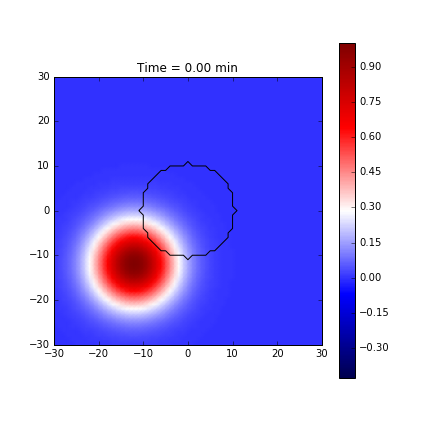
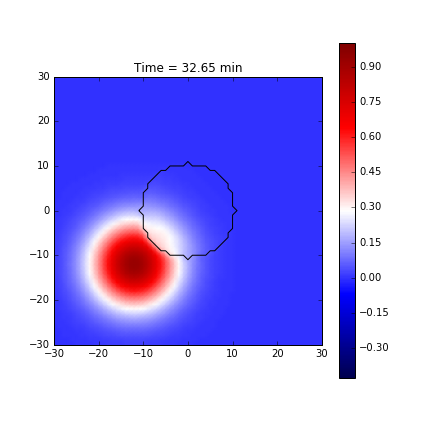
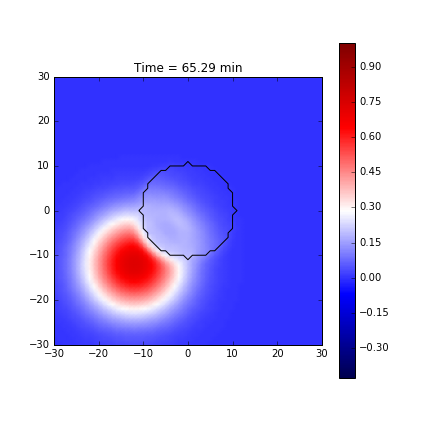
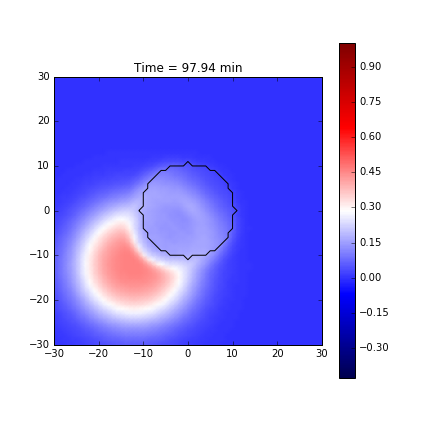
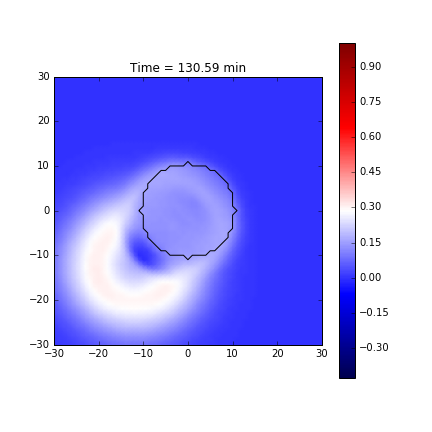
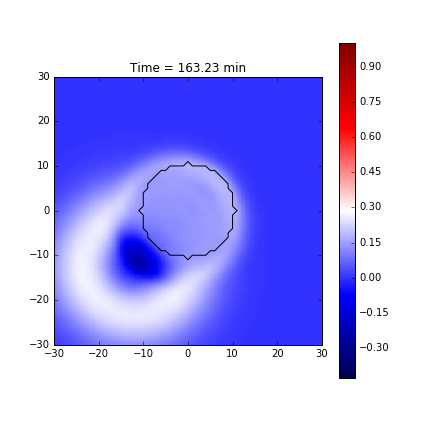
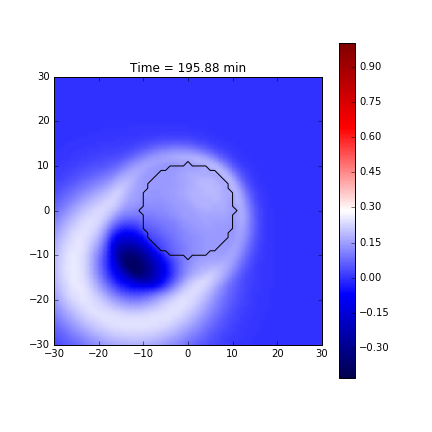
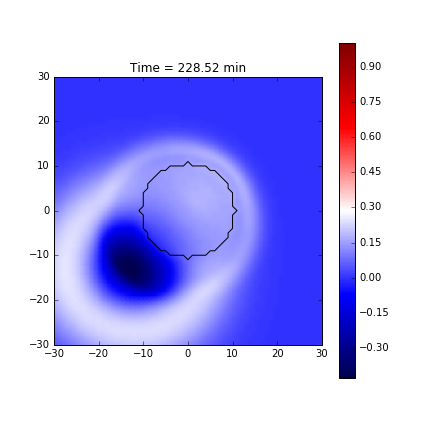
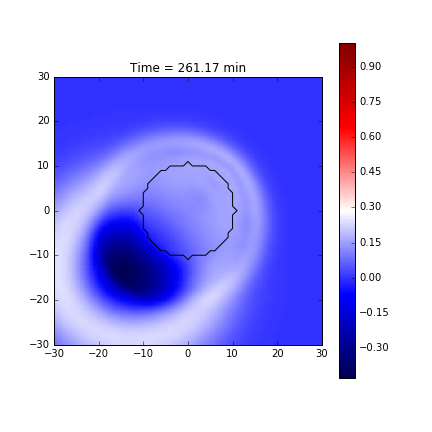
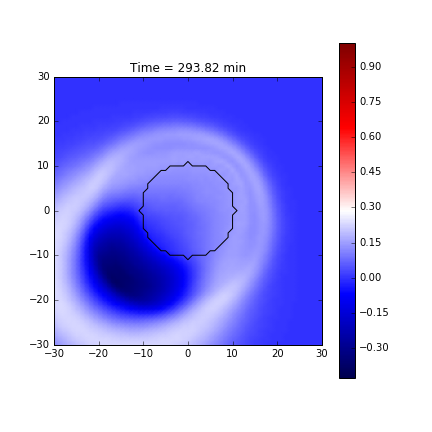
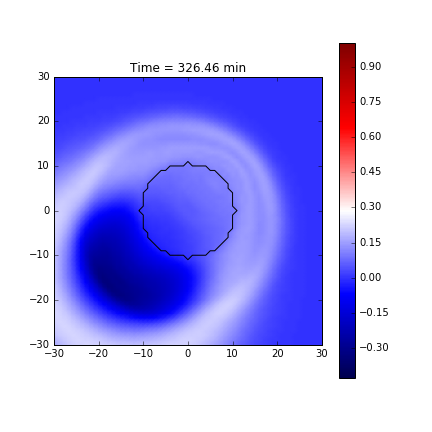
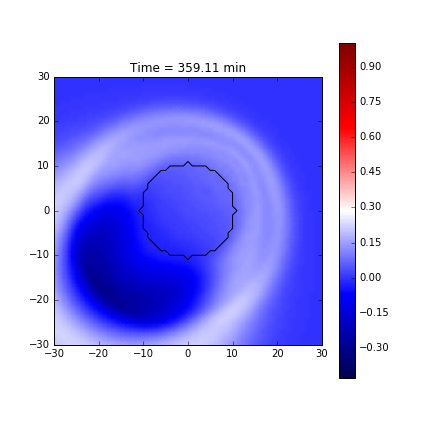
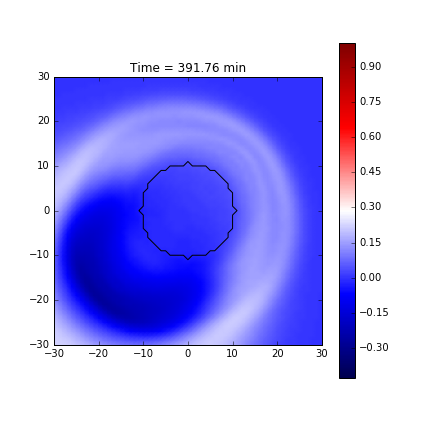
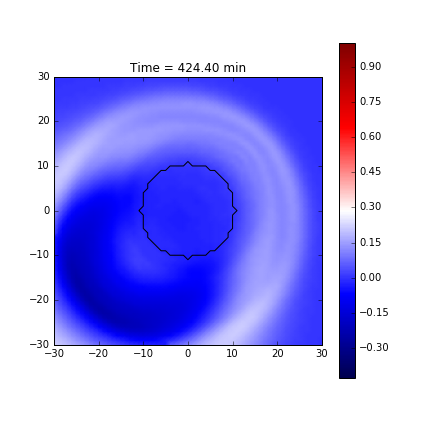
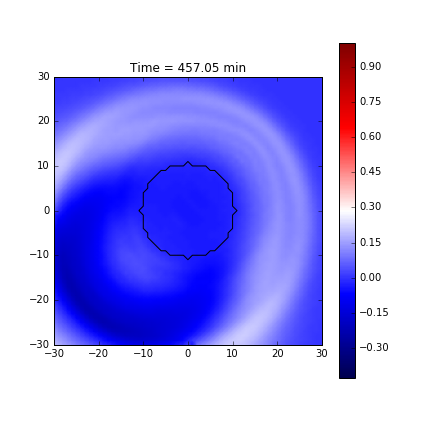
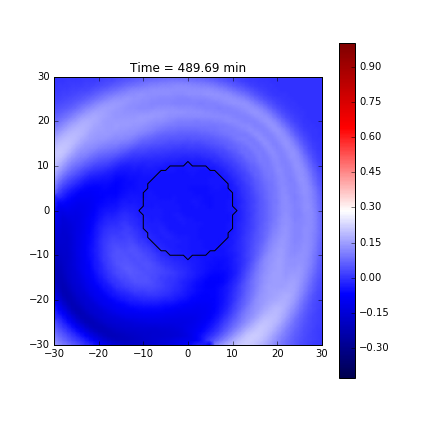
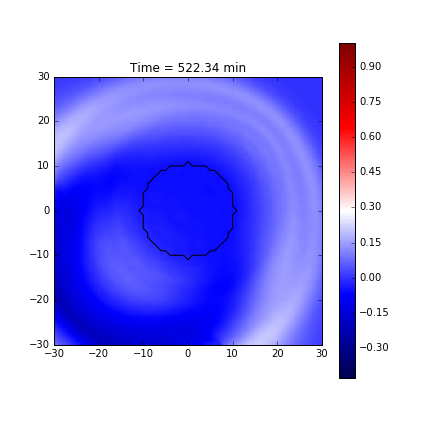
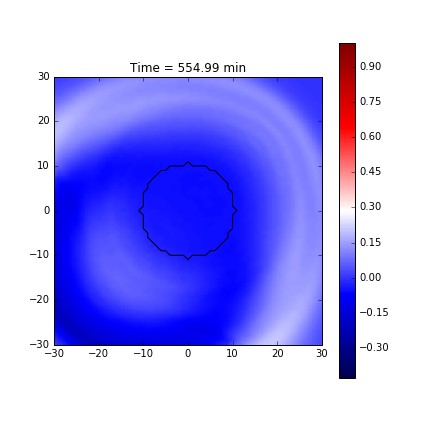
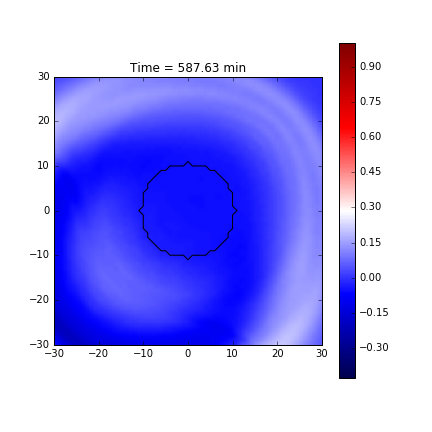
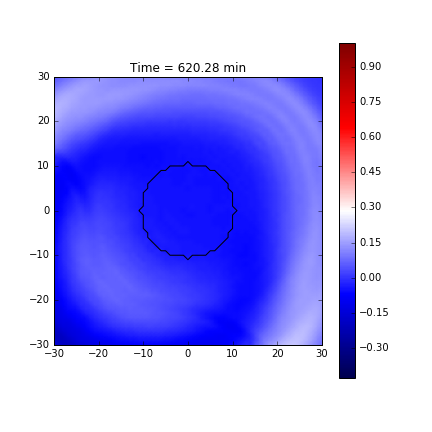

In [24]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure(figsize=(6,6))
ax2 = fig.add_subplot(111)
quad1 = ax2.pcolormesh(xmesh,ymesh,eta[0,:,:],vmax=eta.max(),vmin=eta.min(),
                       shading='gouraud',cmap=plt.cm.seismic)
# plt.pcolormesh(xmesh,ymesh,np.ma.masked_where(h>0,-h),vmin=0.0,vmax=8000, cmap=plt.cm.Greens_r)
ax2.contour(xmesh,ymesh,h,[h.min()],colors='k')
# ax2.contour(xmesh,ymesh,h,[-10.,-100.,-1000.],colors='w')
# ax2.set_axis_off()
t = ax2.set_title('Time = %.2f min'%(0.0))
# ax2.set_xlim(-10,5)
# ax2.set_ylim(-5,5)
cb2 = fig.colorbar(quad1,ax=ax2)
ax2.set_aspect('equal')
def init():
    quad1.set_array([])
    return quad1,


def animate(i):
    j = i*10
    t.set_text('Time = %.2f min'%(j*dt/60))
    quad1.set_array(np.ma.masked_where(h<0,eta[j,:,:]).ravel())
    return quad1,

animation.FuncAnimation(fig, animate, init_func=init,
                        frames=20, interval=100)

Comparar masa

In [19]:
print 'rx vs R1',R1.min(),R1.max()
print 'ry vs R11*R6',(R11*R6).min(),(R11*R6).max()

rx vs R1 0.00175963924576 0.00203185638444
ry vs R11*R6 0.00175070671066 0.00176843777752


Comparar momentum

In [20]:
print 'grxH vs R2', R2.min(), R2.max()
print 'gryH vs R4', R4.min(), R4.max()

grxH vs R2 17.2620610009 87.3861738133
gryH vs R4 17.2620610009 86.3103050046


$\Delta x$ real

In [21]:
R_earth*dx*rad_min

111317.09969219811

El R2 teórico

In [22]:
9.81*h.min()*dt/(R_earth*dx*rad_min), R2.min()

(17.262061000918013, 17.262061000918017)

In [23]:
R2.min()

17.262061000918017